In [ ]:
# default_exp learner

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.notebook.showdoc import *
from local.optimizer import *

In [ ]:
#export
_all_ = ['CancelFitException', 'CancelEpochException', 'CancelTrainException', 'CancelValidException', 'CancelBatchException']

# Learner

> Basic class for handling the training loop

We'll use the following for testing purposes (a basic linear regression problem):

In [ ]:
from torch.utils.data import TensorDataset

def synth_dbunch(a=2, b=3, bs=16, n_train=10, n_valid=2, cuda=False):
    def get_data(n):
        x = torch.randn(bs*n)
        return TensorDataset(x, a*x + b + 0.1*torch.randn(bs*n))
    train_ds = get_data(n_train)
    valid_ds = get_data(n_valid)
    tfms = Cuda() if cuda else None
    train_dl = TfmdDL(train_ds, bs=bs, shuffle=True, after_batch=tfms, num_workers=0)
    valid_dl = TfmdDL(valid_ds, bs=bs, after_batch=tfms, num_workers=0)
    return DataBunch(train_dl, valid_dl)

class RegModel(Module):
    def __init__(self): self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x*self.a + self.b

## Callback - 

In [ ]:
#export core
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1   = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [ ]:
test_eq(camel2snake('ClassAreCamel'), 'class_are_camel')

In [ ]:
#export
def class2attr(self, cls_name):
    return camel2snake(re.sub(rf'{cls_name}$', '', self.__class__.__name__) or cls_name.lower())

In [ ]:
#export
@docs
class Callback():
    "Basic class handling tweaks of the training loop by changing a `Learner` in various events"
    def __call__(self, event_name): getattr(self, event_name, noop)()
    def __repr__(self): return self.__class__.__name__
    def __getattr__(self, k):
        if k=='learn': raise AttributeError
        if not hasattr(self,'learn'): raise AttributeError
        return getattr(self.learn, k)

    @property
    def name(self):
        "Name of the `Callback`, camel-cased and with '*Callback*' removed"
        return class2attr(self, 'Callback')

    _docs=dict(__call__="Call `self.{event_name}` if it's defined",
               __getattr__="Passthrough to get the attributes of `self.learn`")

The training loop is defined in `Learner` a bit below and consists in a minimal set of instructions: looping through the data we:
- compute the output of the model from the input
- calculate a loss between this output and the desired target
- compute the gradients of this loss with respect to all the model parameters
- update the parameters accordingly
- zero all the gradients

Any tweak of this training loop is defined in a `Callback` to avoid over-complicating the code of the training loop, and to make it easy to mix and match different techniques (since they'll be defined in different callbacks). A callback can implement actions on the following events:

- `begin_fit`: called before doing anything, ideal for initial setup.
- `begin_epoch`: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
- `begin_train`: called at the beginning of the training part of an epoch.
- `begin_batch`: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
- `after_pred`: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
- `after_loss`: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
- `after_backward`: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
- `after_step`: called after the step and before the gradients are zeroed.
- `after_batch`: called at the end of a batch, for any clean-up before the next one.
- `after_train`: called at the end of the training phase of an epoch.
- `begin_validate`: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
- `after_validate`: called at the end of the validation part of an epoch.
- `after_epoch`: called at the end of an epoch, for any clean-up before the next one.
- `after_fit`: called at the end of training, for final clean-up.

In [ ]:
show_doc(Callback.__call__)

<h4 id="Callback.__call__" class="doc_header"><code>Callback.__call__</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>Callback.__call__</code>(**`event_name`**)

Call `self.{event_name}` if it's defined

In [ ]:
tst_cb = Callback()
tst_cb.call_me = lambda: print("maybe")
test_stdout(lambda: tst_cb("call_me"), "maybe")

In [ ]:
show_doc(Callback.__getattr__)

<h4 id="Callback.__getattr__" class="doc_header"><code>Callback.__getattr__</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>Callback.__getattr__</code>(**`k`**)

Passthrough to get the attributes of `self.learn`

This is a shortcut to avoid having to write `self.learn.bla` for any `bla` attribute we seek, and just write `self.bla`.

In [ ]:
mk_class('TstLearner', 'a')

class TstCallback(Callback):
    def batch_begin(self): print(self.a)

learn,cb = TstLearner(1),TstCallback()
cb.learn = learn
test_stdout(lambda: cb('batch_begin'), "1")

Note that it only works to get the value of the attribute, if you want to change it, you have to manually access it with `self.learn.bla`. In the example below, `self.a += 1` creates an `a` attribute of 2 in the callback instead of setting the `a` of the learner to 2:

In [ ]:
class TstCallback(Callback):
    def batch_begin(self): self.a += 1

learn,cb = TstLearner(1),TstCallback()
cb.learn = learn
cb('batch_begin')
test_eq(cb.a, 2)
test_eq(cb.learn.a, 1)

A proper version needs to write `self.learn.a = self.a + 1`:

In [ ]:
class TstCallback(Callback):
    def batch_begin(self): self.learn.a = self.a + 1

learn,cb = TstLearner(1),TstCallback()
cb.learn = learn
cb('batch_begin')
test_eq(cb.learn.a, 2)

In [ ]:
show_doc(Callback.name, name='Callback.name')

<h4 id="Callback.name" class="doc_header"><code>Callback.name</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Name of the [`Callback`](/learner.html#Callback), camel-cased and with '*Callback*' removed

In [ ]:
test_eq(TstCallback().name, 'tst')
class ComplicatedNameCallback(Callback): pass
test_eq(ComplicatedNameCallback().name, 'complicated_name')

### TrainEvalCallback -

In [ ]:
#export
class TrainEvalCallback(Callback):
    "`Callback` that tracks the number of iterations done and properly sets training/eval mode"
    def begin_fit(self):
        "Set the iter and epoch counters to 0, put the model and the right device"
        self.learn.train_iter,self.learn.pct_train = 0,0.
        self.model.to(self.dbunch.device)

    def after_batch(self):
        "Update the iter counter (in training mode)"
        if not self.training: return
        self.learn.pct_train += 1./(self.n_iter*self.n_epoch)
        self.learn.train_iter   += 1

    def begin_train(self):
        "Set the model in training mode"
        self.learn.pct_train=self.epoch/self.n_epoch
        self.model.train()
        self.learn.training=True

    def begin_validate(self):
        "Set the model in validation mode"
        self.model.eval()
        self.learn.training=False

In [ ]:
show_doc(TrainEvalCallback, title_level=3)

<h3 id="TrainEvalCallback" class="doc_header"><code>class</code> <code>TrainEvalCallback</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>TrainEvalCallback</code>() :: [`Callback`](/learner.html#Callback)

[`Callback`](/learner.html#Callback) that tracks the number of iterations done and properly sets training/eval mode

This `Callback` is automatically added in every `Learner` at initialization.

In [ ]:
#hide
#test of the TrainEvalCallback below in Learner.fit

In [ ]:
show_doc(TrainEvalCallback.begin_fit)

<h4 id="TrainEvalCallback.begin_fit" class="doc_header"><code>TrainEvalCallback.begin_fit</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_fit</code>()

Set the iter and epoch counters to 0, put the model and the right device

In [ ]:
show_doc(TrainEvalCallback.after_batch)

<h4 id="TrainEvalCallback.after_batch" class="doc_header"><code>TrainEvalCallback.after_batch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.after_batch</code>()

Update the iter counter (in training mode)

In [ ]:
show_doc(TrainEvalCallback.begin_train)

<h4 id="TrainEvalCallback.begin_train" class="doc_header"><code>TrainEvalCallback.begin_train</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_train</code>()

Set the model in training mode

In [ ]:
show_doc(TrainEvalCallback.begin_validate)

<h4 id="TrainEvalCallback.begin_validate" class="doc_header"><code>TrainEvalCallback.begin_validate</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_validate</code>()

Set the model in validation mode

### GatherPredsCallback -

In [ ]:
#export
class GatherPredsCallback(Callback):
    "`Callback` that saves the predictions and targets, optionally `with_loss`"
    def __init__(self, with_loss=False): self.with_loss = with_loss

    def begin_validate(self):
        "Initialize containers"
        self.preds,self.targets = [],[]
        if self.with_loss: self.losses = []

    def after_batch(self):
        "Save predictions, targets and potentially losses"
        self.preds.append(to_detach(self.pred))
        self.targets.append(to_detach(self.yb))
        if self.with_loss: self.losses.append(to_detach(self.loss))

In [ ]:
show_doc(GatherPredsCallback, title_level=3)

<h3 id="GatherPredsCallback" class="doc_header"><code>class</code> <code>GatherPredsCallback</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>GatherPredsCallback</code>(**`with_loss`**=*`False`*) :: [`Callback`](/learner.html#Callback)

[`Callback`](/learner.html#Callback) that saves the predictions and targets, optionally `with_loss`

In [ ]:
show_doc(GatherPredsCallback.begin_validate)

<h4 id="GatherPredsCallback.begin_validate" class="doc_header"><code>GatherPredsCallback.begin_validate</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>GatherPredsCallback.begin_validate</code>()

Initialize containers

In [ ]:
show_doc(GatherPredsCallback.after_batch)

<h4 id="GatherPredsCallback.after_batch" class="doc_header"><code>GatherPredsCallback.after_batch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>GatherPredsCallback.after_batch</code>()

Save predictions, targets and potentially losses

## Callbacks control flow

It happens that we may want to skip some of the steps of the training loop: in gradient accumulation, we don't aways want to do the step/zeroing of the grads for instance. During an LR finder test, we don't want to do the validation phase of an epoch. Or if we're training with a strategy of early stopping, we want to be able to completely interrupt the training loop.

This is made possible by raising specific exceptions the training loop will look for (and properly catch).

In [ ]:
#export
_ex_docs = dict(
    CancelFitException="Skip the rest of this batch and go to `after_batch`",
    CancelEpochException="Skip the rest of the training part of the epoch and go to `after_train`",
    CancelTrainException="Skip the rest of the validation part of the epoch and go to `after_validate`",
    CancelValidException="Skip the rest of this epoch and go to `after_epoch`",
    CancelBatchException="Interrupts training and go to `after_fit`")

for c,d in _ex_docs.items(): mk_class(c,sup=Exception,doc=d)

In [ ]:
show_doc(CancelBatchException, title_level=3)

<h3 id="CancelBatchException" class="doc_header"><code>class</code> <code>CancelBatchException</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelBatchException</code>(**\*`args`**, **\*\*`kwargs`**) :: `Exception`

Interrupts training and go to `after_fit`

In [ ]:
show_doc(CancelTrainException, title_level=3)

<h3 id="CancelTrainException" class="doc_header"><code>class</code> <code>CancelTrainException</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelTrainException</code>(**\*`args`**, **\*\*`kwargs`**) :: `Exception`

Skip the rest of the validation part of the epoch and go to `after_validate`

In [ ]:
show_doc(CancelValidException, title_level=3)

<h3 id="CancelValidException" class="doc_header"><code>class</code> <code>CancelValidException</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelValidException</code>(**\*`args`**, **\*\*`kwargs`**) :: `Exception`

Skip the rest of this epoch and go to `after_epoch`

In [ ]:
show_doc(CancelEpochException, title_level=3)

<h3 id="CancelEpochException" class="doc_header"><code>class</code> <code>CancelEpochException</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelEpochException</code>(**\*`args`**, **\*\*`kwargs`**) :: `Exception`

Skip the rest of the training part of the epoch and go to `after_train`

In [ ]:
show_doc(CancelFitException, title_level=3)

<h3 id="CancelFitException" class="doc_header"><code>class</code> <code>CancelFitException</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelFitException</code>(**\*`args`**, **\*\*`kwargs`**) :: `Exception`

Skip the rest of this batch and go to `after_batch`

You can detect one of those exceptions occurred and add code that executes right after with the following events:
- `after_cancel_batch`: reached imediately after a `CancelBatchException` before proceeding to `after_batch`
- `after_cancel_train`: reached imediately after a `CancelTrainException` before proceeding to `after_epoch`
- `after_cancel_valid`: reached imediately after a `CancelValidException` before proceeding to `after_epoch`
- `after_cancel_epoch`: reached imediately after a `CancelEpochException` before proceeding to `after_epoch`
- `after_cancel_fit`: reached imediately after a `CancelFitException` before proceeding to `after_fit`

In [ ]:
# export
_events = 'begin_fit begin_epoch begin_train begin_batch after_pred after_loss \
    after_backward after_step after_cancel_batch after_batch after_cancel_train \
    after_train begin_validate after_cancel_validate after_validate after_cancel_epoch \
    after_epoch after_cancel_fit after_fit'.split()

mk_class('event', **{o:o for o in _events},
         doc="All possible events as attributes to get tab-completion and typo-proofing")

In [ ]:
# export
_all_ = ['event']

In [ ]:
show_doc(event, name='event', title_level=3)

<h3 id="event" class="doc_header"><code>class</code> <code>event</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>event</code>(**\*`args`**, **\*\*`kwargs`**)

All possible events as attributes to get tab-completion and typo-proofing

In [ ]:
event.after_backward

'after_backward'

Here's the full list: *begin_fit begin_epoch begin_train begin_batch after_pred after_loss after_backward after_step after_cancel_batch after_batch after_cancel_train after_train begin_validate after_cancel_validate after_validate after_cancel_epoch after_epoch after_cancel_fit after_fit*.

In [ ]:
#hide
#Full test of the control flow below, after the Learner class

## Learner -

In [ ]:
# export
defaults.lr = slice(3e-3)
defaults.wd = 1e-2
defaults.callbacks = [TrainEvalCallback]

In [ ]:
# export
def replacing_yield(o, attr, val):
    "Context manager to temporarily replace an attribute"
    old = getattr(o,attr)
    try:     yield setattr(o,attr,val)
    finally: setattr(o,attr,old)

In [ ]:
# export
class Learner():
    def __init__(self, dbunch, model, loss_func=None, opt_func=SGD, lr=defaults.lr, splitter=trainable_params, cbs=None,
                 cb_funcs=None, metrics=None, path=None, model_dir='models', wd_bn_bias=False, train_bn=True):
        store_attr(self, "dbunch,model,opt_func,lr,splitter,model_dir,wd_bn_bias,train_bn")
        self.training,self.logger,self.opt,self.cbs = False,print,None,L()
        #TODO: infer loss_func from data
        self.loss_func = CrossEntropyLossFlat() if loss_func is None else loss_func
        self.path = path if path is not None else getattr(dbunch, 'path', Path('.'))
        self.metrics = [m if isinstance(m, Metric) else AvgMetric(m) for m in L(metrics)]
        self.add_cbs(cbf() for cbf in L(defaults.callbacks)+L(cb_funcs))
        self.add_cbs(cbs)

    def add_cbs(self, cbs): L(cbs).mapped(self.add_cb)
    def remove_cbs(self, cbs): L(cbs).mapped(self.remove_cb)

    def add_cb(self, cb):
        assert (not getattr(self, cb.name, None)) or isinstance(getattr(self, cb.name), cb.__class__), \
            f"self.{cb.name} already registered"
        cb.learn = self
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cb(self, cb):
        cb.learn = None
        if hasattr(self, cb.name): delattr(self, cb.name)
        if cb in self.cbs: self.cbs.remove(cb)

    @contextmanager
    def added_cbs(self, cbs):
        self.add_cbs(cbs)
        yield
        self.remove_cbs(cbs)

    def create_opt(self):
        opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        if not self.wd_bn_bias:
            for p in bn_bias_params(self.model): 
                opt.state[p] = {**opt.state.get(p, {}), 'do_wd': False}
        if self.train_bn:
            for p in bn_bias_params(self.model, with_bias=False):
                opt.state[p] = {**opt.state.get(p, {}), 'force_train': True}
        return opt

    def one_batch(self, i, b):
        try:
            self.iter,(self.xb,self.yb) = i,b;              self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.training: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.n_iter = len(self.dl)
        L(self.dl).enumerated().starmapped(self.one_batch)

    def _do_begin_fit(self, n_epoch):
        self.n_epoch,self.loss = n_epoch,tensor(0.)
        self('begin_fit')

    def _do_epoch_train(self):
        self.dl = self.dbunch.train_dl
        try:
            self('begin_train')
            self.all_batches()
        except CancelTrainException: self('after_cancel_train')
        finally:                     self('after_train')

    def _do_epoch_validate(self):
        try:
            self.dl = self.dbunch.valid_dl
            self('begin_validate')
            with torch.no_grad(): self.all_batches()
        except CancelValidException: self('after_cancel_validate')
        finally:                     self('after_validate')

    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False):
        with self.added_cbs(cbs):
            if reset_opt or not self.opt: self.opt = self.create_opt()
            self.opt.set_hyper('lr', self.lr     if lr is None else lr)
            self.opt.set_hyper('wd', defaults.wd if wd is None else wd)

            try:
                self._do_begin_fit(n_epoch)
                for epoch in range(n_epoch):
                    try:
                        self.epoch=epoch;          self('begin_epoch')
                        self._do_epoch_train()
                        self._do_epoch_validate()
                    except CancelEpochException:   self('after_cancel_epoch')
                    finally:                       self('after_epoch')

            except CancelFitException: self('after_cancel_fit')
            finally:                   self('after_fit')

    def validate(self, dl=None, cbs=None):
        self.dl = dl or self.dbunch.valid_dl
        with self.added_cbs(cbs), self.no_logging():
            self(['begin_fit', 'begin_epoch', 'begin_validate'])
            self.all_batches()
            self(['after_validate', 'after_epoch', 'after_fit'])
        return self.recorder.values[-1]

    def get_preds(self, ds_idx=1, with_loss=False):
        self.dl = self.dbunch.dls[ds_idx]
        cb = GatherPredsCallback(with_loss=with_loss)
        with self.no_logging(), self.added_cbs(cb), self.loss_not_reduced():
            self(['begin_fit', 'begin_epoch', 'begin_validate'])
            self.all_batches()
            self(['after_validate', 'after_epoch', 'after_fit'])
            if with_loss: return torch.cat(cb.preds),torch.cat(cb.targets),torch.cat(cb.losses)
            return torch.cat(cb.preds),torch.cat(cb.targets)

    def __call__(self, event_name): L(event_name).mapped(self._call_one)
    def _call_one(self, event_name):
        assert hasattr(event, event_name)
        [cb(event_name) for cb in sort_by_run(self.cbs)]

    @contextmanager
    def no_logging(self): return replacing_yield(self, 'logger', noop)

    @contextmanager
    def loss_not_reduced(self):
        if hasattr(self.loss_func, 'reduction'): return replacing_yield(self.loss_func, 'reduction', 'none')
        else: return replacing_yield(self, 'loss_func', partial(self.loss_func, reduction='none'))
            
    def save(self, file, with_opt=True):
        #TODO: if rank_distrib(): return # don't save if slave proc
        if not hasattr(self, 'opt'): with_opt=False
        if not with_opt: state = get_model(self.model).state_dict()
        else: state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
        torch.save(state, join_path_file(file, self.path/self.model_dir, ext='.pth'))
        
    def load(self, file, with_opt=None, device=None, strict=True):
        if device is None: device = self.dbunch.device
        elif isinstance(device, int): device = torch.device('cuda', device)
        state = torch.load(join_path_file(file, self.path/self.model_dir, ext='.pth'))
        if set(state.keys()) == {'model', 'opt'}:
            model_state = state['model']
            get_model(self.model).load_state_dict(model_state, strict=strict)
            if ifnone(with_opt,True):
                if self.opt is None: self.opt = self.create_opt()
                try:    self.opt.load_state_dict(state['opt'])
                except:
                    if with_opt: warn("Could not load the optimizer state.")
        else:
            if with_opt: warn("Saved filed doesn't contain an optimizer state.")
            get_model(self.model).load_state_dict(state, strict=strict)
        return self

In [ ]:
add_docs(Learner, "Group together a `model`, some `dbunch` and a `loss_func` to handle training",
    add_cbs="Add `cbs` to the list of `Callback` and register `self` as their learner",
    add_cb="Add `cb` to the list of `Callback` and register `self` as their learner",
    remove_cbs="Remove `cbs` from the list of `Callback` and deregister `self` as their learner",
    remove_cb="Add `cb` from the list of `Callback` and deregister `self` as their learner",
    added_cbs="Context manage that temporarily adds `cbs`",
    create_opt="Create an optimizer with `lr`",
    one_batch="Train or evaluate `self.model` on batch `(xb,yb)`",
    all_batches="Train or evaluate `self.model` on all batches of `self.dl`",
    fit="Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.",
    validate="Validate on `dl` with potential new `cbs`.",
    get_preds="Get the predictions and targets on the `ds_idx`-th dbunchset, optionally `with_loss`",
    no_logging="Context manager to temporarily remove `logger`",
    loss_not_reduced="A context manager to evaluate `loss_func` with reduction set to none.",
    save="Save model and optimizer state (if `with_opt`) to `self.path/self.model_dir/file`",
    load="Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`"
)

`opt_func` will be used to create an optimizer when `Learner.fit` is called, with `lr` as a learning rate. `splitter` is a function taht takes `self.model` and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is `trainable_params`, which returns all trainable parameters of the model.

`cbs` is one or a list of `Callback`s  to pass to the `Learner`, and `cb_funcs` is one or a list of functions returning a `Callback` that will be called at init. Each `Callback` is registered as an attribute of `Learner` (with camel case). At creation, all the callbacks in `defaults.callbacks` (`TrainEvalCallback` and `Recorder`) are associated to the `Learner`.

`metrics` is an optional list of metrics, that can be either functions or `Metric`s (see below).

### Training loop

In [ ]:
#Test init with callbacks
def synth_learner(n_train=10, n_valid=2, cuda=False, **kwargs):
    return Learner(synth_dbunch(n_train=n_train,n_valid=n_valid, cuda=cuda), RegModel(), loss_func=MSELossFlat(), **kwargs)

tst_learn = synth_learner()
test_eq(len(tst_learn.cbs), 1)
assert isinstance(tst_learn.cbs[0], TrainEvalCallback)
assert hasattr(tst_learn, ('train_eval'))

tst_learn = synth_learner(cbs=TstCallback())
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

tst_learn = synth_learner(cb_funcs=TstCallback)
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

#A name that becomes an existing attribute of the Learner will throw an exception (here add_cb)
class AddCbCallback(Callback): pass
test_fail(lambda: synth_learner(cbs=AddCbCallback()))

In [ ]:
show_doc(Learner.fit)

<h4 id="Learner.fit" class="doc_header"><code>Learner.fit</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L81" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.fit</code>(**`n_epoch`**, **`lr`**=*`None`*, **`wd`**=*`None`*, **`cbs`**=*`None`*, **`reset_opt`**=*`False`*)

Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.

In [ ]:
#Training a few epochs should make the model better
learn = synth_learner(cb_funcs=TstCallback)
xb,yb = learn.dbunch.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit(2)
assert learn.loss < init_loss

In [ ]:
#hide
#Test of TrainEvalCallback
class TestTrainEvalCallback(Callback):
    run_after=TrainEvalCallback
    def begin_fit(self): 
        test_eq([self.pct_train,self.train_iter], [0., 0])
        self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def begin_batch(self): test_eq(next(self.model.parameters()).device, find_device(self.xb))
    
    def after_batch(self):
        if self.training:
            test_eq(self.pct_train , self.old_pct_train+1/(self.n_iter*self.n_epoch))
            test_eq(self.train_iter, self.old_train_iter+1)
            self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def begin_train(self):
        assert self.training and self.model.training
        test_eq(self.pct_train, self.epoch/self.n_epoch)
        self.old_pct_train = self.pct_train
    
    def begin_validate(self):
        assert not self.training and not self.model.training
        
learn = synth_learner(cb_funcs=TestTrainEvalCallback)
learn.fit(1)
#Check order is properly taken into account
learn.cbs = L(reversed(learn.cbs))

In [ ]:
#hide
#cuda
#Check model is put on the GPU if needed
learn = synth_learner(cb_funcs=TestTrainEvalCallback, cuda=True)
learn.fit(1)

In [ ]:
#hide
#Check wd is not applied on bn/bias when option wd_bn_bias=False
class _TstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
        self.tst = nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(3))
        self.tst[0].bias.data,self.tst[1].bias.data = torch.randn(5),torch.randn(3) 
    def forward(self, x): return x * self.a + self.b
    
class _PutGrad(Callback):
    def after_backward(self):
        for p in self.learn.model.tst.parameters():
            p.grad = torch.ones_like(p.data)
    
learn = synth_learner(n_train=5, opt_func = partial(SGD, wd=1, true_wd=True), cb_funcs=_PutGrad)
learn.model = _TstModel()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1, lr=1e-2)
end = list(learn.model.tst.parameters())
assert not torch.allclose(end[0]-init[0], -0.05 * torch.ones_like(end[0]))
for i in [1,2,3]: test_close(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

In [ ]:
show_doc(Learner.one_batch)

<h4 id="Learner.one_batch" class="doc_header"><code>Learner.one_batch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L45" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.one_batch</code>(**`i`**, **`b`**)

Train or evaluate `self.model` on batch `(xb,yb)`

This is an internal method called by `Learner.fit`. If passed, `i` is the index of this iteration in the epoch. In training method, this does a full training step on the batch (compute predictions, loss, gradients, update the model parameters and zero the gradients). In validation mode, it stops at the loss computation.

In [ ]:
# export
class VerboseCallback(Callback):
    "Callback that prints the name of each event called"
    def __call__(self, event_name):
        print(event_name)
        super().__call__(event_name)

In [ ]:
#hide
class TestOneBatch(VerboseCallback):
    def __init__(self, xb, yb, i):
        self.save_xb,self.save_yb,self.i = xb,yb,i
        self.old_pred,self.old_loss = None,tensor(0.)
        
    def begin_batch(self):
        self.old_a,self.old_b = self.model.a.data.clone(),self.model.b.data.clone()
        test_eq(self.iter,    self.i)
        test_eq(self.save_xb, self.xb)
        test_eq(self.save_yb, self.yb)
        if hasattr(self.learn, 'pred'): test_eq(self.pred, self.old_pred)
    
    def after_pred(self):
        self.old_pred = self.pred
        test_eq(self.pred, self.model.a.data * self.xb + self.model.b.data)
        test_eq(self.loss, self.old_loss)
    
    def after_loss(self):
        self.old_loss = self.loss
        test_eq(self.loss, self.loss_func(self.old_pred, self.save_yb))
        for p in self.model.parameters(): 
            if not hasattr(p, 'grad') or p.grad is not None: test_eq(p.grad, tensor([0.]))
    
    def after_backward(self):
        self.grad_a = (2 * self.xb * (self.pred.data - self.yb)).mean()
        self.grad_b = 2 * (self.pred.data - self.yb).mean()
        test_close(self.model.a.grad.data, self.grad_a)
        test_close(self.model.b.grad.data, self.grad_b)
        test_eq(self.model.a.data, self.old_a)
        test_eq(self.model.b.data, self.old_b)
        
    def after_step(self):
        test_close(self.model.a.data, self.old_a - self.lr * self.grad_a)
        test_close(self.model.b.data, self.old_b - self.lr * self.grad_b)
        self.old_a,self.old_b = self.model.a.data.clone(),self.model.b.data.clone()
        test_close(self.model.a.grad.data, self.grad_a)
        test_close(self.model.b.grad.data, self.grad_b)
    
    def after_batch(self):
        for p in self.model.parameters(): test_eq(p.grad, tensor([0.]))

In [ ]:
#hide
learn = synth_learner()
b = learn.dbunch.one_batch()
learn = synth_learner(cbs=TestOneBatch(*b, 42), lr=1e-2)
#Remove train/eval
learn.cbs = learn.cbs[1:]
#Setup
learn.loss,learn.training = tensor(0.),True
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
learn.model.train()
batch_events = ['begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step', 'after_batch']
test_stdout(lambda: learn.one_batch(42, b), '\n'.join(batch_events))
test_stdout(lambda: learn.one_batch(42, b), '\n'.join(batch_events)) #Check it works for a second batch

In [ ]:
show_doc(Learner.all_batches)

<h4 id="Learner.all_batches" class="doc_header"><code>Learner.all_batches</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L57" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.all_batches</code>()

Train or evaluate `self.model` on all batches of `self.dl`

In [ ]:
#hide
learn = synth_learner(n_train=5, cbs=VerboseCallback())
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
with redirect_stdout(io.StringIO()): 
    learn._do_begin_fit(1)
    learn.epoch,learn.dl = 0,learn.dbunch.train_dl
    learn('begin_epoch')
    learn('begin_train')
test_stdout(learn.all_batches, '\n'.join(batch_events * 5))
test_eq(learn.train_iter, 5)

valid_events = ['begin_batch', 'after_pred', 'after_loss', 'after_batch']
with redirect_stdout(io.StringIO()): 
    learn.dl = learn.dbunch.valid_dl
    learn('begin_validate')
test_stdout(learn.all_batches, '\n'.join(valid_events * 2))
test_eq(learn.train_iter, 5)

In [ ]:
#hide
learn = synth_learner(n_train=5, cbs=VerboseCallback())
test_stdout(lambda: learn._do_begin_fit(42), 'begin_fit')
test_eq(learn.n_epoch, 42)
test_eq(learn.loss, tensor(0.))

In [ ]:
#hide
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
learn.epoch = 0
test_stdout(lambda: learn._do_epoch_train(), '\n'.join(['begin_train'] + batch_events * 5 + ['after_train']))

In [ ]:
#hide
test_stdout(learn._do_epoch_validate, '\n'.join(['begin_validate'] + valid_events * 2+ ['after_validate']))

### Serializing

In [ ]:
show_doc(Learner.save)

<h4 id="Learner.save" class="doc_header"><code>Learner.save</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L131" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.save</code>(**`file`**, **`with_opt`**=*`True`*)

Save model and optimizer state (if `with_opt`) to `self.path/self.model_dir/file`

`file` can be a `Path`, a `string` or a buffer.

In [ ]:
show_doc(Learner.load)

<h4 id="Learner.load" class="doc_header"><code>Learner.load</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L138" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.load</code>(**`file`**, **`with_opt`**=*`None`*, **`device`**=*`None`*, **`strict`**=*`True`*)

Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using [`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)

`file` can be a `Path`, a `string` or a buffer. Use `device` to load the model/optimizer state on a device different from the one it was saved.

In [ ]:
learn = synth_learner(cb_funcs=TstCallback, opt_func=partial(SGD, mom=0.9))
xb,yb = learn.dbunch.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit(1)
learn.save('tmp')
assert (Path.cwd()/'models/tmp.pth').exists()

learn1 = synth_learner(cb_funcs=TstCallback, opt_func=partial(SGD, mom=0.9))
learn1 = learn1.load('tmp')
test_eq(learn.model.a, learn1.model.a)
test_eq(learn.model.b, learn1.model.b)
test_eq(learn.opt.state_dict(), learn1.opt.state_dict())

learn.save('tmp1', with_opt=False)
learn1 = synth_learner(cb_funcs=TstCallback, opt_func=partial(SGD, mom=0.9))
learn1 = learn1.load('tmp1')
test_eq(learn.model.a, learn1.model.a)
test_eq(learn.model.b, learn1.model.b)
assert learn1.opt is None

shutil.rmtree('models')

### Callback handling

In [ ]:
show_doc(Learner.__call__)

<h4 id="Learner.__call__" class="doc_header"><code>Learner.__call__</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L118" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.__call__</code>(**`event_name`**)

Call self as a function.

In [ ]:
show_doc(Learner.add_cb)

<h4 id="Learner.add_cb" class="doc_header"><code>Learner.add_cb</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L17" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cb</code>(**`cb`**)

Add `cb` to the list of [`Callback`](/learner.html#Callback) and register `self` as their learner

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
test_eq(len(learn.cbs), 2)
assert isinstance(learn.cbs[1], TestTrainEvalCallback)
test_eq(learn.train_eval.learn, learn)

In [ ]:
show_doc(Learner.add_cbs)

<h4 id="Learner.add_cbs" class="doc_header"><code>Learner.add_cbs</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cbs</code>(**`cbs`**)

Add `cbs` to the list of [`Callback`](/learner.html#Callback) and register `self` as their learner

In [ ]:
learn.add_cbs([TestTrainEvalCallback(), TestTrainEvalCallback()])
test_eq(len(learn.cbs), 4)

In [ ]:
show_doc(Learner.remove_cb)

<h4 id="Learner.remove_cb" class="doc_header"><code>Learner.remove_cb</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cb</code>(**`cb`**)

Add `cb` from the list of [`Callback`](/learner.html#Callback) and deregister `self` as their learner

In [ ]:
cb = learn.cbs[1]
learn.remove_cb(learn.cbs[1])
test_eq(len(learn.cbs), 3)
assert cb.learn is None
assert not getattr(learn,'test_train_eval',None)

In [ ]:
show_doc(Learner.remove_cbs)

<h4 id="Learner.remove_cbs" class="doc_header"><code>Learner.remove_cbs</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cbs</code>(**`cbs`**)

Remove `cbs` from the list of [`Callback`](/learner.html#Callback) and deregister `self` as their learner

In [ ]:
cb = learn.cbs[1]
learn.remove_cbs(learn.cbs[1:])
test_eq(len(learn.cbs), 1)

When writing a callback, the following attributes of `Learner` are available:
- `model`: the model used for training/validation
- `data`: the underlying `DataBunch`
- `loss_func`: the loss function used
- `opt`: the optimizer used to udpate the model parameters
- `opt_func`: the function used to create the optimizer
- `cbs`: the list containing all `Callback`s
- `dl`: current `DataLoader` used for iteration
- `xb`: last input drawn from `self.dl` (potentially modified by callbacks)
- `yb`: last target drawn from `self.dl` (potentially modified by callbacks)
- `pred`: last predictions from `self.model` (potentially modified by callbacks)
- `loss`: last computed loss (potentially modified by callbacks)
- `n_epoch`: the number of epochs in this training
- `n_iter`: the number of iterations in the current `self.dl`
- `epoch`: the current epoch index (from 0 to `n_epoch-1`)
- `iter`: the current iteration index in `self.dl` (from 0 to `n_iter-1`)

The following attributes are added by `TrainEvalCallback` and should be available unless you went out of your way to remove that callback:

- `train_iter`: the number of training iterations done since the beginning of this training
- `pct_train`: from 0. to 1., the percentage of training iterations completed
- `training`:  flag to indicate if we're in training mode or not

The following attribute is added by `Recorder` and should be available unless you went out of your way to remove that callback:

- `smooth_loss`: an exponentially-averaged version of the training loss

### Control flow testing

In [ ]:
#hide
batch_events  = ['begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step', 'after_batch']
batchv_events = ['begin_batch', 'after_pred', 'after_loss', 'after_batch']
train_events  = ['begin_train']    + batch_events  + ['after_train']
valid_events  = ['begin_validate'] + batchv_events + ['after_validate']
epoch_events  = ['begin_epoch'] + train_events + valid_events + ['after_epoch']
cycle_events  = ['begin_fit'] + epoch_events + ['after_fit']

In [ ]:
#hide
learn = synth_learner(n_train=1, n_valid=1)
test_stdout(lambda: learn.fit(1, cbs=VerboseCallback()), '\n'.join(cycle_events))

In [ ]:
#hide
class TestCancelCallback(VerboseCallback):
    def __init__(self, cancel_at=event.begin_batch, exception=CancelBatchException, train=None):
        def _interrupt(): 
            if train is None or train == self.training: raise exception()
        setattr(self, cancel_at, _interrupt)

In [ ]:
#hide
#test cancel batch
for i,e in enumerate(batch_events[:-1]):
    be = batch_events[:i+1] + ['after_cancel_batch', 'after_batch']
    bev = be if i <3 else batchv_events
    cycle = cycle_events[:3] + be + ['after_train', 'begin_validate'] + bev + cycle_events[-3:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(cancel_at=e)), '\n'.join(cycle))

#CancelBatchException not caught if thrown in any other event
for e in cycle_events:
    if e not in batch_events[:-1]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(cancel_at=e)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually

In [ ]:
#hide
#test cancel train
for i,e in enumerate(['begin_train'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 and i < len(batch_events) else []) 
    be += ['after_cancel_train', 'after_train']
    cycle = cycle_events[:3] + be + ['begin_validate'] + batchv_events + cycle_events[-3:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelTrainException, True)), '\n'.join(cycle))

#CancelTrainException not caught if thrown in any other event
for e in cycle_events:
    if e not in ['begin_train'] + batch_events[:-1]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelTrainException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#hide
#test cancel valid
for i,e in enumerate(['begin_validate'] + batchv_events):
    bev = batchv_events[:i] + (['after_batch'] if i >=1 and i < len(batchv_events) else []) + ['after_cancel_validate']
    cycle = cycle_events[:3] + batch_events + ['after_train', 'begin_validate'] + bev + cycle_events[-3:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelValidException, False)), '\n'.join(cycle))
    
#CancelValidException not caught if thrown in any other event
for e in cycle_events:
    if e not in ['begin_validate'] + batch_events[:3]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelValidException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#hide
#test cancel epoch
#In train
for i,e in enumerate(['begin_train'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 and i<len(batch_events) else []) 
    cycle = cycle_events[:3] + be + ['after_train', 'after_cancel_epoch'] + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelEpochException, True)), '\n'.join(cycle))

#In valid
for i,e in enumerate(['begin_validate'] + batchv_events):
    bev = batchv_events[:i] + (['after_batch'] if i >=1 and i<len(batchv_events) else [])
    cycle = cycle_events[:3] + batch_events + ['after_train', 'begin_validate'] + bev 
    cycle += ['after_validate', 'after_cancel_epoch'] + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelEpochException, False)), '\n'.join(cycle))

#In begin epoch
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_epoch', CancelEpochException, False)), 
            '\n'.join(cycle_events[:2] + ['after_cancel_epoch'] + cycle_events[-2:]))

#CancelEpochException not caught if thrown in any other event
for e in ['begin_fit', 'after_epoch', 'after_fit']:
    if e not in ['begin_validate'] + batch_events[:3]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelEpochException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#hide
#test cancel fit
#In begin fit
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_fit', CancelFitException)), 
            '\n'.join(['begin_fit', 'after_cancel_fit', 'after_fit']))

#In begin epoch
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_epoch', CancelFitException, False)), 
            '\n'.join(cycle_events[:2] + ['after_epoch', 'after_cancel_fit', 'after_fit']))
#In train
for i,e in enumerate(['begin_train'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 and i<len(batch_events) else []) 
    cycle = cycle_events[:3] + be + ['after_train', 'after_epoch', 'after_cancel_fit', 'after_fit']
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelFitException, True)), '\n'.join(cycle))
    
#In valid
for i,e in enumerate(['begin_validate'] + batchv_events):
    bev = batchv_events[:i] + (['after_batch'] if i >=1 and i<len(batchv_events) else [])
    cycle = cycle_events[:3] + batch_events + ['after_train', 'begin_validate'] + bev 
    cycle += ['after_validate', 'after_epoch', 'after_cancel_fit', 'after_fit']
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelFitException, False)), '\n'.join(cycle))
    
#CancelEpochException not caught if thrown in any other event
with redirect_stdout(io.StringIO()):
    cb = TestCancelCallback('after_fit', CancelEpochException)
    test_fail(lambda: learn.fit(1, cbs=cb))
    learn.remove_cb(cb) #Have to remove it manually  

## Metrics -

In [ ]:
#export
@docs
class Metric():
    "Blueprint for defining a metric"
    def reset(self):             pass
    def accumulate(self, learn): pass
    @property
    def value(self): raise NotImplementedError

    @property
    def name(self): return class2attr(self, 'Metric')

    _docs = {'reset': "Reset inner state to prepare for new computation",
            'name': "Name of the `Metric`, camel-cased and with Metric removed",
            'accumulate': "Use `learn` to update the state with new results",
            'value': "The value of the metric"}

In [ ]:
show_doc(Metric, title_level=3)

<h3 id="Metric" class="doc_header"><code>class</code> <code>Metric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Metric</code>()

Blueprint for defining a metric

Metrics can be simple averages (like accuracy) but sometimes their computation is a little bit more complex and can't be averaged over batches (like precision or recall), which is why we need a special class for them. For simple functions that can be computed as averages over batches, we can use the class `AvgMetric`, otherwise you'll need to implement the following methods.

> Note: If your `Metric` has state depending on tensors, don't forget to store it on the CPU to avoid any potential memory leaks.

In [ ]:
show_doc(Metric.reset)

<h4 id="Metric.reset" class="doc_header"><code>Metric.reset</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.reset</code>()

Reset inner state to prepare for new computation

In [ ]:
show_doc(Metric.accumulate)

<h4 id="Metric.accumulate" class="doc_header"><code>Metric.accumulate</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.accumulate</code>(**`learn`**)

Use `learn` to update the state with new results

In [ ]:
show_doc(Metric.value, name='Metric.value')

<h4 id="Metric.value" class="doc_header"><code>Metric.value</code><a href="" class="source_link" style="float:right">[source]</a></h4>

The value of the metric

In [ ]:
show_doc(Metric.name, name='Metric.name')

<h4 id="Metric.name" class="doc_header"><code>Metric.name</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Name of the [`Metric`](/learner.html#Metric), camel-cased and with Metric removed

In [ ]:
#export
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += to_detach(self.func(learn.pred, learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.__name__

In [ ]:
show_doc(AvgMetric, title_level=3)

<h3 id="AvgMetric" class="doc_header"><code>class</code> <code>AvgMetric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgMetric</code>(**`func`**) :: [`Metric`](/learner.html#Metric)

Average the values of `func` taking into account potential different batch sizes

In [ ]:
learn = synth_learner()
tst = AvgMetric(lambda x,y: (x-y).abs().mean())
t,u = torch.randn(100),torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.pred,learn.yb = t[i:i+25],u[i:i+25]
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#hide
#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.pred,learn.yb = t[splits[i]:splits[i+1]],u[splits[i]:splits[i+1]]
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#export
class AvgLoss(Metric):
    "Average the losses taking into account potential different batch sizes"
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += to_detach(learn.loss)*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "loss"

In [ ]:
show_doc(AvgLoss, title_level=3)

<h3 id="AvgLoss" class="doc_header"><code>class</code> <code>AvgLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgLoss</code>() :: [`Metric`](/learner.html#Metric)

Average the losses taking into account potential different batch sizes

In [ ]:
tst = AvgLoss()
t = torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.yb,learn.loss = t[i:i+25],t[i:i+25].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#hide
#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.yb,learn.loss = t[splits[i]:splits[i+1]],t[splits[i]:splits[i+1]].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#export
class AvgSmoothLoss(Metric):
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): self.beta = beta
    def reset(self):               self.count,self.val = 0,tensor(0.)
    def accumulate(self, learn):
        self.count += 1
        self.val = torch.lerp(to_detach(learn.loss), self.val, self.beta)
    @property
    def value(self): return self.val/(1-self.beta**self.count)

In [ ]:
show_doc(AvgSmoothLoss, title_level=3)

<h3 id="AvgSmoothLoss" class="doc_header"><code>class</code> <code>AvgSmoothLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgSmoothLoss</code>(**`beta`**=*`0.98`*) :: [`Metric`](/learner.html#Metric)

Smooth average of the losses (exponentially weighted with `beta`)

In [ ]:
tst = AvgSmoothLoss()
t = torch.randn(100)
tst.reset()
val = tensor(0.)
for i in range(4): 
    learn.loss = t[i*25:(i+1)*25].mean()
    tst.accumulate(learn)
    val = val*0.98 + t[i*25:(i+1)*25].mean()*(1-0.98)
    test_close(val/(1-0.98**(i+1)), tst.value)

## Recorder --

In [ ]:
#export
from fastprogress.fastprogress import format_time

def _maybe_item(t):
    return t.item() if t.numel()==1 else t

class Recorder(Callback):
    "Callback that registers statistics (lr, loss and metrics) during training"
    run_after = TrainEvalCallback

    def __init__(self, add_time=True, train_metrics=False, beta=0.98):
        self.add_time,self.train_metrics = add_time,train_metrics
        self.loss,self.smooth_loss = AvgLoss(),AvgSmoothLoss(beta=beta)

    def begin_fit(self):
        "Prepare state for training"
        self.lrs,self.losses,self.values = [],[],[]
        names = [m.name for m in self._valid_mets]
        if self.train_metrics: names = [f'train_{n}' for n in names] + [f'valid_{n}' for n in names]
        else:                  names = ['train_loss', 'valid_loss'] + names[1:]
        if self.add_time: names.append('time')
        self.metric_names = ['epoch']+names
        self.smooth_loss.reset()

    def after_batch(self):
        "Update all metrics and records lr and smooth loss in training"
        mets = [self.smooth_loss] + self._train_mets if self.training else self._valid_mets
        for met in mets: met.accumulate(self.learn)
        if not self.training: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.smooth_loss.value)
        self.learn.smooth_loss = self.smooth_loss.value

    def begin_epoch(self):
        "Set timer if `self.add_time=True`"
        self.cancel_train,self.cancel_valid = False,False
        if self.add_time: self.start_epoch = time.time()
        self.log = [getattr(self, 'epoch', 0)]

    def begin_train   (self): [m.reset() for m in self._train_mets]
    def after_train   (self): self.log += [_maybe_item(m.value) for m in self._train_mets]
    def begin_validate(self): [m.reset() for m in self._valid_mets]
    def after_validate(self): self.log += [_maybe_item(m.value) for m in self._valid_mets]

    def after_cancel_train(self):    self.cancel_train = True
    def after_cancel_validate(self): self.cancel_valid = True

    def after_epoch(self):
        "Store and log the loss/metric values"
        self.values.append(self.log[1:].copy())
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        self.logger(self.log)

    @property
    def _train_mets(self):
        if getattr(self, 'cancel_train', False): return []
        return [self.loss] + (self.metrics if self.train_metrics else [])
    @property
    def _valid_mets(self):
        if getattr(self, 'cancel_valid', False): return []
        return [self.loss] + self.metrics

    def plot_loss(self): plt.plot(self.losses)

In [ ]:
#export
add_docs(Recorder,
         begin_train = "Reset loss and metrics state",
         after_train = "Log loss and metric values on the training set (if `self.training_metrics=True`)",
         begin_validate = "Reset loss and metrics state",
         after_validate = "Log loss and metric values on the validation set",
         after_cancel_train = "Ignore training metrics for this epoch",
         after_cancel_validate = "Ignore validation metrics for this epoch",
         plot_loss = "Plot the losses")

defaults.callbacks = [TrainEvalCallback, Recorder]

By default, metrics are computed on the validation set only, although that can be changed with `training_metrics=True`. `beta` is the weight used to compute the exponentially weighted average of the losses (which gives the `smooth_loss` attribute to `Learner`).

In [ ]:
#Test printed output
def tst_metric(out, targ): return F.mse_loss(out, targ)
learn = synth_learner(n_train=5, metrics=tst_metric)
pat = r"[tensor\(\d.\d*\), tensor\(\d.\d*\), tensor\(\d.\d*\), 'dd:dd']"
test_stdout(lambda: learn.fit(1), pat, regex=True)

In [ ]:
#hide
class TestRecorderCallback(Callback):
    run_after=Recorder
    
    def begin_fit(self): 
        self.train_metrics,self.add_time = self.recorder.train_metrics,self.recorder.add_time
        self.beta = self.recorder.smooth_loss.beta
        for m in self.metrics: assert isinstance(m, Metric)
        test_eq(self.recorder.smooth_loss.val, 0.)
        #To test what the recorder logs, we use a custom logger function.
        self.learn.logger = self.test_log
        self.old_smooth,self.count = tensor(0.),0
    
    def after_batch(self):
        if self.training:
            self.count += 1
            test_eq(len(self.recorder.lrs), self.count)
            test_eq(self.recorder.lrs[-1], self.opt.hypers[-1]['lr'])
            test_eq(len(self.recorder.losses), self.count)
            smooth = (1 - self.beta**(self.count-1)) * self.old_smooth * self.beta + self.loss * (1-self.beta)
            smooth /= 1 - self.beta**self.count
            test_close(self.recorder.losses[-1], smooth, eps=1e-4)
            test_close(self.smooth_loss, smooth, eps=1e-4)
            self.old_smooth = self.smooth_loss
        self.bs += find_bs(self.yb)
        test_eq(self.recorder.loss.count, self.bs)
        if self.train_metrics or not self.training: 
            for m in self.metrics: test_eq(m.count, self.bs)
        self.losses.append(self.loss.detach().cpu())
    
    def begin_epoch(self): 
        if self.add_time: self.start_epoch = time.time()
        self.log = [self.epoch]
    
    def begin_train(self):
        self.bs = 0
        self.losses = []
        for m in self.recorder._train_mets: test_eq(m.count, self.bs)
            
    def after_train(self):
        res = tensor(self.losses).mean()
        self.log += [res, res] if self.train_metrics else [res]
        test_eq(self.log, self.recorder.log)
        self.losses = []
    
    def begin_validate(self):
        self.bs = 0
        self.losses = []
        for m in [self.recorder.loss] + self.metrics: test_eq(m.count, self.bs)
    
    def test_log(self, log):
        res = tensor(self.losses).mean()
        self.log += [res, res]
        if self.add_time: self.log.append(format_time(time.time() - self.start_epoch))
        test_eq(log, self.log)

In [ ]:
#hide
learn = synth_learner(n_train=5, metrics = tst_metric, cb_funcs = TestRecorderCallback)
learn.fit(1)
test_eq(learn.recorder.metric_names, ['epoch', 'train_loss', 'valid_loss', 'tst_metric', 'time'])

learn = synth_learner(n_train=5, metrics = tst_metric, cb_funcs = TestRecorderCallback)
learn.recorder.train_metrics=True
learn.fit(1)
test_eq(learn.recorder.metric_names, 
        ['epoch', 'train_loss', 'train_tst_metric', 'valid_loss', 'valid_tst_metric', 'time'])

learn = synth_learner(n_train=5, metrics = tst_metric, cb_funcs = TestRecorderCallback)
learn.recorder.add_time=False
learn.fit(1)
test_eq(learn.recorder.metric_names, ['epoch', 'train_loss', 'valid_loss', 'tst_metric'])

### Callback internals

In [ ]:
show_doc(Recorder.begin_fit)

<h4 id="Recorder.begin_fit" class="doc_header"><code>Recorder.begin_fit</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_fit</code>()

Prepare state for training

In [ ]:
show_doc(Recorder.begin_epoch)

<h4 id="Recorder.begin_epoch" class="doc_header"><code>Recorder.begin_epoch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L34" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_epoch</code>()

Set timer if `self.add_time=True`

In [ ]:
show_doc(Recorder.begin_validate)

<h4 id="Recorder.begin_validate" class="doc_header"><code>Recorder.begin_validate</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L42" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_validate</code>()

Reset loss and metrics state

In [ ]:
show_doc(Recorder.after_batch)

<h4 id="Recorder.after_batch" class="doc_header"><code>Recorder.after_batch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_batch</code>()

Update all metrics and records lr and smooth loss in training

In [ ]:
show_doc(Recorder.after_epoch)

<h4 id="Recorder.after_epoch" class="doc_header"><code>Recorder.after_epoch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L48" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_epoch</code>()

Store and log the loss/metric values

### Ploting tools

In [ ]:
show_doc(Recorder.plot_loss)

<h4 id="Recorder.plot_loss" class="doc_header"><code>Recorder.plot_loss</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L63" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.plot_loss</code>()

Plot the losses

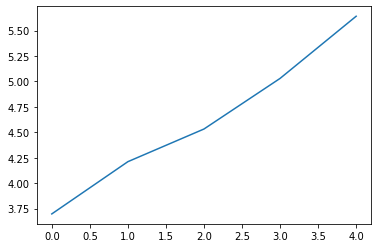

In [ ]:
#hide
learn.recorder.plot_loss()

## Inference functions

In [ ]:
show_doc(Learner.no_logging)

<h4 id="Learner.no_logging" class="doc_header"><code>Learner.no_logging</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L123" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.no_logging</code>()

Context manager to temporarily remove `logger`

In [ ]:
learn = synth_learner(n_train=5, metrics=tst_metric)
with learn.no_logging():
    test_stdout(lambda: learn.fit(1), '')
test_eq(learn.logger, print)

In [ ]:
show_doc(Learner.validate)

<h4 id="Learner.validate" class="doc_header"><code>Learner.validate</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L100" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.validate</code>(**`dl`**=*`None`*, **`cbs`**=*`None`*)

Validate on `dl` with potential new `cbs`.

In [ ]:
#Test result
learn = synth_learner(n_train=5, metrics=tst_metric)
res = learn.validate()
test_eq(res[0], res[1])
x,y = learn.dbunch.valid_ds.tensors
test_close(res[0], F.mse_loss(learn.model(x), y))

In [ ]:
#hide
#Test other dl
res = learn.validate(learn.dbunch.train_dl)
test_eq(res[0], res[1])
x,y = learn.dbunch.train_ds.tensors
test_close(res[0], F.mse_loss(learn.model(x), y))

#Test additional callback is executed.
cycle = cycle_events[:2] + ['begin_validate'] + batchv_events * 2 + cycle_events[-3:]
test_stdout(lambda: learn.validate(cbs=VerboseCallback()), '\n'.join(cycle))

In [ ]:
show_doc(Learner.loss_not_reduced)

<h4 id="Learner.loss_not_reduced" class="doc_header"><code>Learner.loss_not_reduced</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L126" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.loss_not_reduced</code>()

A context manager to evaluate `loss_func` with reduction set to none.

In [ ]:
#hide
test_eq(learn.loss_func.reduction, 'mean')
with learn.loss_not_reduced():
    test_eq(learn.loss_func.reduction, 'none')
    x,y = learn.dbunch.one_batch()
    p = learn.model(x)
    losses = learn.loss_func(p, y)
    test_eq(losses.shape, y.shape)
    test_eq(losses, F.mse_loss(p,y, reduction='none'))
test_eq(learn.loss_func.reduction, 'mean')

In [ ]:
show_doc(Learner.get_preds)

<h4 id="Learner.get_preds" class="doc_header"><code>Learner.get_preds</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L108" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_preds</code>(**`ds_idx`**=*`1`*, **`with_loss`**=*`False`*)

Get the predictions and targets on the `ds_idx`-th dbunchset, optionally `with_loss`

> Warning: If your dataset is unlabelled, the targets will all be 0s.

> Note: If you want to use the option `with_loss=True` on a custom loss function, make sure you have implemented a `reduction` attribute that supports 'none' 

In [ ]:
#Test result
learn = synth_learner(n_train=5, metrics=tst_metric)
preds,targs = learn.get_preds()
x,y = learn.dbunch.valid_ds.tensors
test_eq(targs, y)
test_close(preds, learn.model(x))

In [ ]:
#hide
#Test other dataset
x = torch.randn(16*5)
y = 2*x + 3 + 0.1*torch.randn(16*5)
dl = TfmdDL(TensorDataset(x, y), bs=16)
learn.dbunch.dls += (dl,)
preds,targs = learn.get_preds(ds_idx=2)
test_eq(targs, y)
test_close(preds, learn.model(x))

#Test with loss
preds,targs,losses = learn.get_preds(ds_idx=2, with_loss=True)
test_eq(targs, y)
test_close(preds, learn.model(x))
test_close(losses, F.mse_loss(preds, targs, reduction='none'))

## Transfer learning

In [ ]:
#export
@patch
def freeze_to(self:Learner, n):
    if self.opt is None: self.opt = self.create_opt()
    self.opt.freeze_to(n)

@patch
def freeze(self:Learner): self.freeze_to(-1)

@patch
def unfreeze(self:Learner): self.freeze_to(0)    

In [ ]:
add_docs(Learner, 
         freeze_to="Freeze parameter groups up to `n`",
         freeze="Freeze up to last parameter group",
         unfreeze="Unfreeze the entire model")

In [ ]:
#hide
class _TstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
        self.tst = nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(3))
        self.tst[0].bias.data,self.tst[1].bias.data = torch.randn(5),torch.randn(3) 
    def forward(self, x): return x * self.a + self.b
    
class _PutGrad(Callback):
    def after_backward(self):
        for p in self.learn.model.tst.parameters():
            if p.requires_grad: p.grad = torch.ones_like(p.data)

def _splitter(m): return [list(m.tst[0].parameters()), list(m.tst[1].parameters()), [m.a,m.b]]
            
learn = synth_learner(n_train=5, opt_func = partial(SGD), cb_funcs=_PutGrad, splitter=_splitter, lr=1e-2)
learn.model = _TstModel()
learn.freeze()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1)
end = list(learn.model.tst.parameters())
#linear was not trained
for i in [0,1]: assert torch.allclose(end[i],init[i])
#bn was trained even frozen since `train_bn=True` by default
for i in [2,3]: assert torch.allclose(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

[0, 23.44908332824707, 14.924123764038086, '00:00']


In [ ]:
#hide
learn = synth_learner(n_train=5, opt_func = partial(SGD), cb_funcs=_PutGrad, splitter=_splitter, train_bn=False, lr=1e-2)
learn.model = _TstModel()
learn.freeze()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1)
end = list(learn.model.tst.parameters())
#linear and bn were not trained
for i in range(4): assert torch.allclose(end[i],init[i])

learn.freeze_to(-2)
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1)
end = list(learn.model.tst.parameters())
#linear was not trained
for i in [0,1]: assert torch.allclose(end[i],init[i])
#bn was trained 
for i in [2,3]: assert torch.allclose(end[i]-init[i], -0.05 * torch.ones_like(end[i]))
    
learn.unfreeze()
init = [p.clone() for p in learn.model.tst.parameters()]
learn.fit(1)
end = list(learn.model.tst.parameters())
#linear and bn were trained
for i in range(4): assert torch.allclose(end[i]-init[i], -0.05 * torch.ones_like(end[i]))

[0, 6.280836582183838, 7.317409515380859, '00:00']
[0, 5.270134925842285, 6.166843414306641, '00:00']
[0, 4.431342601776123, 5.200370788574219, '00:00']


## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.